<a href="https://colab.research.google.com/github/sjernigan/gan_expirements/blob/main/v_diffusion_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [v-diffusion-pytorch](https://github.com/crowsonkb/v-diffusion-pytorch)

By Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings)

and JD Pressman (https://twitter.com/jd_pressman).

Notebook by BoneAmputee (https://twitter.com/BoneAmputee).

**Be aware** that you must manually switch to 512x512 for the yfcc models, and the repo's default iterations is 1000, not 100.

# Setup

In [ ]:
!pip install ftfy
%cd /content/
!git clone https://github.com/crowsonkb/v-diffusion-pytorch.git
%cd v-diffusion-pytorch
!git clone https://github.com/openai/CLIP.git
%mkdir -p checkpoints

     |████████████████████████████████| 64 kB 1.4 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=e031c40e73aab60c2cd008fb836258cdd4a992d927a2af44eb6dbf66f23b9224
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
/content
Cloning into 'v-diffusion-pytorch'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 91 (delta 41), reused 45 (delta 23), pack-reused 26
Unpacking objects: 100% (91/91), done.
/content/v-diffusion-pytorch
Cloning into 'CLIP'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 195 (delta 12), reused 22 (delta 9), pack-reused 168
Receiving objects: 100% (195/195), 8.91 MiB | 30.92 MiB/s, done.
Resolving deltas: 100% (92/92), done.


# Run

Using device: cuda:0


100%|███████████████████████████████████████| 335M/335M [00:04<00:00, 77.8MiB/s]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

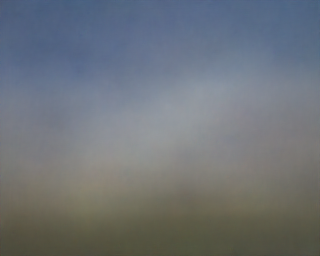

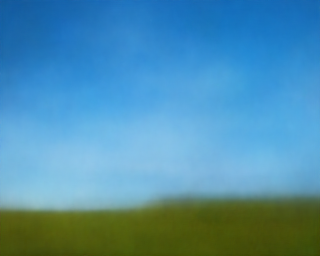

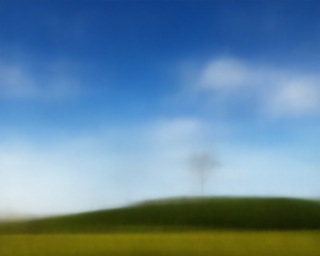

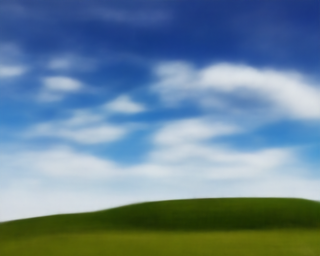

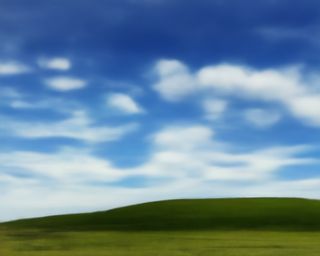

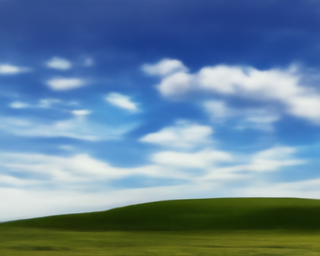

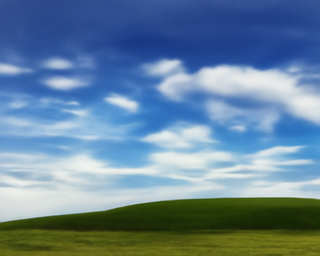

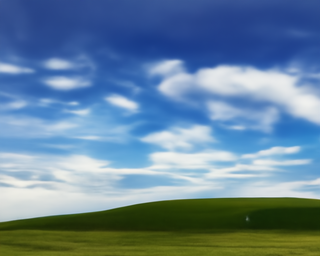

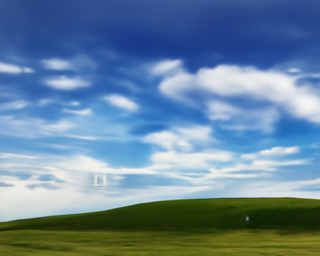

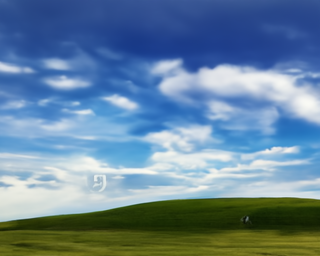

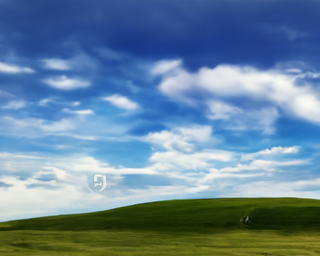

In [ ]:
#!/usr/bin/env python3

"""CLIP guided sampling from a diffusion model."""

import argparse
from functools import partial
from pathlib import Path

from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import trange
from IPython import display
from shutil import rmtree
import os
import hashlib

from CLIP import clip
from diffusion import get_model, get_models, sampling, utils

MODULE_DIR = Path("/content/v-diffusion-pytorch/").resolve()

def download_model(model):
  models = {
      'cc12m_1_cfg':{
          'hash':'4fc95ee1b3205a3f7422a07746383776e1dbc367eaf06a5b658ad351e77b7bda',
          'url':'https://v-diffusion.s3.us-west-2.amazonaws.com/cc12m_1_cfg.pth'},
      'cc12m_1':{
          'hash':'63946d1f6a1cb54b823df818c305d90a9c26611e594b5f208795864d5efe0d1f',
          'url':'https://v-diffusion.s3.us-west-2.amazonaws.com/cc12m_1.pth'},
      'yfcc_1':{
          'hash':'a1c0f6baaf89cb4c461f691c2505e451ff1f9524744ce15332b7987cc6e3f0c8',
          'url':'https://v-diffusion.s3.us-west-2.amazonaws.com/yfcc_1.pth'},
      'yfcc_2':{
          'hash':'69ad4e534feaaebfd4ccefbf03853d5834231ae1b5402b9d2c3e2b331de27907',
          'url':'https://v-diffusion.s3.us-west-2.amazonaws.com/yfcc_2.pth'},
  }
  if model in list(models):
    save_path = f"checkpoints/{model}.pth"
    if os.path.exists(save_path):
      sha256_hash = hashlib.sha256()
      with open(save_path, 'rb') as f:
          for byte_block in iter(lambda: f.read(4096),b''):
              sha256_hash.update(byte_block)
      if str(sha256_hash.hexdigest()) != models[model]['hash']:
        print(f"{sha256_hash.hexdigest()} != {models[model]['hash']}")
        print(f"Redownloading {model}...")
        os.remove(save_path)
        os.system(f"curl -L \"{models[model]['url']}\" > \"{save_path}\"")
    else:
      print(f"Downloading {model}...")
      os.system(f"curl -L \"{models[model]['url']}\" > \"{save_path}\"")
  else:
    print("download_model function received erroneous input.")


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutout = F.adaptive_avg_pool2d(cutout, self.cut_size)
            cutouts.append(cutout)
        return torch.cat(cutouts)


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])


def resize_and_center_crop(image, size):
    fac = max(size[0] / image.size[0], size[1] / image.size[1])
    image = image.resize((int(fac * image.size[0]), int(fac * image.size[1])), Image.LANCZOS)
    return TF.center_crop(image, size[::-1])


def main():

    #@markdown `prompts`: the text prompts to use. Relative weights for text prompts can be specified by putting the weight after a colon. The vertical bar character can be used to denote multiple prompts.
    prompts = "Windows XP \"Bliss\" wallpaper, trending on ArtStation" #@param {type:"string"}
    #@markdown `batch_size`: sample this many images at a time (default 1)
    batch_size = 1 #@param {type:"integer"}
    #@markdown `checkpoint`: manually specify the model checkpoint file
    checkpoint = "" #@param {type:"string"}
    #@markdown `clip_guidance_scale`: how strongly the result should match the text prompt (default 500). If set to 0, the cc12m_1 model will still be CLIP conditioned and sampling will go faster and use less memory.
    clip_guidance_scale = 500 #@param {type:"number"}
    #@markdown `device`: the PyTorch device name to use (default autodetects)
    device = "cuda:0" #@param {type:"string"}
    #@markdown `eta`: set to 0 for deterministic (DDIM) sampling, 1 (the default) for stochastic (DDPM) sampling, and in between to interpolate between the two. DDIM is preferred for low numbers of timesteps.
    eta = 1.0 #@param {type:"number"}
    #@markdown `images`: the image prompts to use (local files or HTTP(S) URLs). Relative weights for image prompts can be specified by putting the weight after a colon, for example: `"image_1.png:0.5"`.
    images = "" #@param {type:"string"}
    #@markdown `model`: specify the model to use (default cc12m_1)
    model = "cc12m_1" #@param ["cc12m_1_cfg","cc12m_1", "yfcc_1", "yfcc_2"]
    #@markdown `n`: sample until this many images are sampled (default 1)
    n = 1 #@param {type:"integer"}
    #@markdown `seed`: specify the random seed (default 0)
    seed = 0 #@param {type:"integer"}
    #@markdown `steps`: specify the number of diffusion timesteps (default is 1000, can lower for faster but lower quality sampling)
    steps = 100 #@param {type:"integer"}
    #@markdown `image_checkin`: specify the number of steps between each image update
    image_checkin = 10 #@param {type:"integer"}
    #@markdown `video_checkin`: specify the number of steps between each image update for video creation
    global video_checkin
    video_checkin = 1 #@param {type:"integer"}
    #@markdown `cutn`: specify the number of cuts to observe when guiding
    cutn = 16 #@param {type:"integer"}
    #@markdown `cut_pow`: specify the cut power
    cut_pow = 1.0 #@param {type:"number"}
    #@markdown `width`: specify the width
    width =  320#@param {type:"integer"}
    #@markdown `height`: specify the height
    height = 256 #@param {type:"integer"}
    #@markdown `init`: specify the init image (optional)
    init = '' #@param {type:"string"}
    #@markdown `init_mode`: specify the init image mode
    init_mode = 'crop to fill' #@param ["crop to fill", "stretch to fill"]
    #@markdown `starting_timestep`: specify the starting timestep if an init image is used (range 0-1, default 0.9)
    starting_timestep = 0.9 #@param {type:"number"}

    prompts = [x.strip() for x in prompts.split('|')]
    prompts = [x for x in prompts if x != '']
    images = [x.strip() for x in images.split('|')]
    images = [x for x in images if x != '']

    args = argparse.Namespace(
      prompts = prompts,
      batch_size = batch_size,
      checkpoint = checkpoint,
      clip_guidance_scale = clip_guidance_scale,
      device = device,
      eta = eta,
      images = images,
      model = model,
      n = n,
      seed = seed,
      steps = steps,
      image_checkin = image_checkin,
      video_checkin = video_checkin,
      cutn = cutn,
      cut_pow = cut_pow,
      width = width,
      height = height,
      init = init,
      init_mode = init_mode,
      starting_timestep = starting_timestep,
    )

    if args.device:
        device = torch.device(args.device)
    else:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)

    download_model(args.model)
    model = get_model(args.model)()
    s = model.shape[1]//4
    side_y, side_x = (args.height//s)*s, (args.width//s)*s
    checkpoint = args.checkpoint
    if not checkpoint:
        checkpoint = MODULE_DIR / f'checkpoints/{args.model}.pth'
    model.load_state_dict(torch.load(checkpoint, map_location='cpu'))
    if device.type == 'cuda':
        model = model.half()
    model = model.to(device).eval().requires_grad_(False)
    clip_model_name = model.clip_model if hasattr(model, 'clip_model') else 'ViT-B/16'
    clip_model = clip.load(clip_model_name, jit=False, device=device)[0]
    clip_model.eval().requires_grad_(False)
    normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                     std=[0.26862954, 0.26130258, 0.27577711])
    make_cutouts = MakeCutouts(clip_model.visual.input_resolution, args.cutn, args.cut_pow)

    if args.init:
        init = Image.open(utils.fetch(args.init)).convert('RGB')
        if args.init_mode == 'crop to fill':
          init = resize_and_center_crop(init, (side_x, side_y))
        elif args.init_mode == 'stretch to fill':
          init = init.resize((side_x, side_y), Image.LANCZOS)
        init = utils.from_pil_image(init).cuda()[None].repeat([args.n, 1, 1, 1])

    zero_embed = torch.zeros([1, clip_model.visual.output_dim], device=device)
    target_embeds, weights = [], []

    if 'cfg' in args.model:
      target_embeds = [zero_embed]

    for prompt in args.prompts:
        txt, weight = parse_prompt(prompt)
        target_embeds.append(clip_model.encode_text(clip.tokenize(txt).to(device)).float())
        weights.append(weight)

    for prompt in args.images:
        path, weight = parse_prompt(prompt)
        img = Image.open(utils.fetch(path)).convert('RGB')
        clip_size = clip_model.visual.input_resolution

        img = TF.resize(img, min(side_x, side_y, *img.size), transforms.InterpolationMode.LANCZOS)
        batch = make_cutouts(TF.to_tensor(img)[None].to(device))
        embeds = F.normalize(clip_model.encode_image(normalize(batch)).float(), dim=-1)
        target_embeds.append(embeds)
        weights.extend([weight / args.cutn] * args.cutn)

    if not target_embeds:
        raise RuntimeError('At least one text or image prompt must be specified.')
    target_embeds = torch.cat(target_embeds)
    weights = torch.tensor(weights, device=device)
    if weights.sum().abs() < 1e-3:
        raise RuntimeError('The weights must not sum to 0.')
    weights /= weights.sum().abs()

    clip_embed = F.normalize(target_embeds.mul(weights[:, None]).sum(0, keepdim=True), dim=-1)
    clip_embed = clip_embed.repeat([args.n, 1])

    torch.manual_seed(args.seed)

    def colab_callback(data):
        i, pred = data['i'], data['pred']
        outfile = f'frames/{str(i).zfill(4)}.png'
        if i % video_checkin == 0:
          utils.to_pil_image(pred).save(outfile)
        if i % image_checkin == 0:
          if not i % video_checkin == 0:
            utils.to_pil_image(pred).save(outfile)
          display.display(display.Image(outfile))

    def cond_fn(x, t, pred, **kwargs):
        clip_in = normalize(make_cutouts((pred + 1) / 2))
        image_embeds = clip_model.encode_image(clip_in).view([args.cutn, x.shape[0], -1])
        losses = spherical_dist_loss(image_embeds, clip_embed[None])
        loss = losses.mean(0).sum() * args.clip_guidance_scale
        grad = -torch.autograd.grad(loss, x)[0]
        return grad

    def cfg_model_fn(x, t):
        n = x.shape[0]
        n_conds = len(target_embeds)
        x_in = x.repeat([n_conds, 1, 1, 1])
        t_in = t.repeat([n_conds])
        clip_embed_in = torch.cat([*target_embeds]).repeat_interleave(n, 0)
        vs = model(x_in, t_in, clip_embed_in).view([n_conds, n, *x.shape[1:]])
        v = vs.mul(weights[:, None, None, None, None]).sum(0)
        return v

    def run(x, steps, clip_embed):
        if hasattr(model, 'clip_model'):
            extra_args = {'clip_embed': clip_embed}
            cond_fn_ = cond_fn
        else:
            extra_args = {}
            cond_fn_ = partial(cond_fn, clip_embed=clip_embed)
        if not args.clip_guidance_scale:
            return sampling.sample(model, x, steps, args.eta, extra_args, callback=colab_callback)
        return sampling.cond_sample(model, x, steps, args.eta, extra_args, cond_fn_, callback=colab_callback)

    def cfg_run(x, steps):
        return sampling.sample(cfg_model_fn, x, steps, args.eta, {}, callback=colab_callback)

    def run_all(n, batch_size):
        x = torch.randn([args.n, 3, side_y, side_x], device=device)
        t = torch.linspace(1, 0, args.steps + 1, device=device)[:-1]
        steps = utils.get_spliced_ddpm_cosine_schedule(t)
        if args.init:
            steps = steps[steps < args.starting_timestep]
            alpha, sigma = utils.t_to_alpha_sigma(steps[0])
            x = init * alpha + x * sigma
        for i in trange(0, n, batch_size):
            cur_batch_size = min(n - i, batch_size)
            if not 'cfg' in args.model:
              outs = run(x[i:i+cur_batch_size], steps, clip_embed[i:i+cur_batch_size])
            else:
              outs = cfg_run(x[i:i+cur_batch_size], steps)
            for j, out in enumerate(outs):
                outfile = f'out_{i + j:05}.png'
                utils.to_pil_image(out).save(outfile)
                display.display(display.Image(outfile))

    try:
        run_all(args.n, args.batch_size)
    except KeyboardInterrupt:
        pass


if __name__ == '__main__':
    video_checkin = 1
    if os.path.exists("frames"):
      rmtree("frames")
    os.makedirs("frames")
    main()


In [ ]:
#@title Video
import os, shutil, time
from base64 import b64encode
from IPython.display import HTML
from google.colab.files import download
if os.path.exists('frames'):
  video = f"{int(time.time())}.mp4"
  out_sequence = 'frames/%04d.png'
  if video_checkin != 1:
    frames = list(Path('frames').rglob("*.png"))
    frames = sorted([str(x) for x in frames])
    for i, frame in enumerate(frames):
      shutil.move(frame, f"frames/{str(i+1).zfill(4)}.png")
  os.system(f"ffmpeg -y -v warning -r 15 -i {out_sequence} -c:v libx264 -pix_fmt yuvj420p -crf 18 -an \"{video}\"")
  data_url = "data:video/mp4;base64," + b64encode(open(video,'rb').read()).decode()
  video_html = f"<video controls><source src=\"{data_url}\" type=\"video/mp4\"></video>"
  HTML(video_html)
  download(video)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>